In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import glob
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
%run ./utils.ipynb
%run ./LSTM.ipynb
%run ./CNN_GAN.ipynb

In [2]:
'''Download the database from: https://physionet.org/content/mitdb/1.0.0/'''
paths = glob.glob('C:/Users/1938759.IKB/OneDrive - Brunel University London/05 Datasets/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/*.atr')             
paths.pop(1)

[leadML2, _, labels] = segmentation(paths)

# Normalise signals between [-1 and 1]
leadML2 = normalise(leadML2, -1, 1)

# Filter the signals
leadML2 = Savitzky_Golay(leadML2, fs=360)

# Exclude the signals that have the annotations in exclude_char 
[labels,Normal, AA, LBBB, RBBB] = exclude(labels,leadML2)

# Load LSTM encoders and extract features

RBBB hidden features- encoded using the LSTM-AE

In [3]:
# Convert data in tensor 
# In the line below: Data = pd.DataFrame(x) change the "x" with the name of the desired class for feature extraction 
Data = pd.DataFrame(RBBB)
dataset = Data.astype(np.float32).to_numpy().tolist()
dataset_tensor =[torch.tensor(s).unsqueeze(1) for s in dataset]
n_seq, seq_len, n_features = torch.stack(dataset_tensor).shape

# Extract the hidden features/ encoded signals from the encoder
# 1) Load the encoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
encoder_PATH = r'C:\Users\1938759.IKB\OneDrive - Brunel University London\Projects with Alex\EHRA- abstract\LSTM-AE feature extraction\models\encoder_RBBB.pth'
encoder_model = Encoder(seq_len, n_features, embedding_dim = 32).to(device) # load the encoder to cuda
encoder_model.load_state_dict(torch.load(encoder_PATH))
encoder_model.eval()

RBBB_HF, _ = predict(encoder_model, dataset_tensor)

C:\envs\ailab\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([360, 1])) that is different to the input size (torch.Size([1, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


LBBB hidden features- encoded using the LSTM-AE

In [4]:
# Convert data in tensor 
# In the line below: Data = pd.DataFrame(x) change the "x" with the name of the desired class for feature extraction 
Data = pd.DataFrame(LBBB)
dataset = Data.astype(np.float32).to_numpy().tolist()
dataset_tensor =[torch.tensor(s).unsqueeze(1) for s in dataset]
n_seq, seq_len, n_features = torch.stack(dataset_tensor).shape

# Extract the hidden features/ encoded signals from the encoder
# 1) Load the encoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
encoder_PATH = r'C:\Users\1938759.IKB\OneDrive - Brunel University London\Projects with Alex\EHRA- abstract\LSTM-AE feature extraction\models\LBBB_encoder.pth'
encoder_model = Encoder(seq_len, n_features, embedding_dim = 32).to(device) # load the encoder to cuda
encoder_model.load_state_dict(torch.load(encoder_PATH))
encoder_model.eval()

LBBB_HF, _ = predict(encoder_model, dataset_tensor)

AA hidden features- encoded using LSTM-AE

In [5]:
# Convert data in tensor 
# In the line below: Data = pd.DataFrame(x) change the "x" with the name of the desired class for feature extraction 
Data = pd.DataFrame(AA)
dataset = Data.astype(np.float32).to_numpy().tolist()
dataset_tensor =[torch.tensor(s).unsqueeze(1) for s in dataset]
n_seq, seq_len, n_features = torch.stack(dataset_tensor).shape

# Extract the hidden features/ encoded signals from the encoder
# 1) Load the encoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
encoder_PATH = r'C:\Users\1938759.IKB\OneDrive - Brunel University London\Projects with Alex\EHRA- abstract\LSTM-AE feature extraction\models\AA_encoder.pth'
encoder_model = Encoder(seq_len, n_features, embedding_dim = 32).to(device) # load the encoder to cuda
encoder_model.load_state_dict(torch.load(encoder_PATH))
encoder_model.eval()

AA_HF, _ = predict(encoder_model, dataset_tensor)

Normal hidden features- encoded using LSTM-AE

In [8]:
# Convert data in tensor 
# In the line below: Data = pd.DataFrame(x) change the "x" with the name of the desired class for feature extraction 
Data = pd.DataFrame(Normal)
dataset = Data.astype(np.float32).to_numpy().tolist()
dataset_tensor =[torch.tensor(s).unsqueeze(1) for s in dataset]
n_seq, seq_len, n_features = torch.stack(dataset_tensor).shape

# Extract the hidden features/ encoded signals from the encoder
# 1) Load the encoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
encoder_PATH = r'C:\Users\1938759.IKB\OneDrive - Brunel University London\Projects with Alex\EHRA- abstract\LSTM-AE feature extraction\models\N_encoder.pth'
encoder_model = Encoder(seq_len, n_features, embedding_dim = 32).to(device) # load the encoder to cuda
encoder_model.load_state_dict(torch.load(encoder_PATH))
encoder_model.eval()

Normal_HF, _ = predict(encoder_model, dataset_tensor)

# Training the GAN for synthetic feature generation

Once you extract the real hidden features using the above LSTMs autoencoders please replace the 'hidden_features' list in the trainloader with the specific class that you want to generate synthetic features with 

In [9]:
# Hyperparameters 
lr = 0.0001
batch_size = 4
image_size = 32
channels_img = 1
channels_noise = 12
num_epochs = 150

critic_iterations = 5
LAMBDA_GP = 10

features_d = 16
features_g = 16  # feature maps

no_of_baches = len(Normal_HF)/batch_size

In [10]:
device =  "cuda" if torch.cuda.is_available() else "cpu"
config = {    "learning_rate": lr,
    "batch_size": batch_size,
    "Optimiser": "Adam",
    "epochs": num_epochs,
    "features_d": features_d,
    "features_g": features_g,
    "class": "Normal" }

# replace the 'hidden_features' list in the trainloader with the specific class that you want to generate synthetic features such as 'AA_hidden_features, LBBB_hidden_features'
trainloader = DataLoader(Normal_HF, batch_size= batch_size, shuffle=True,drop_last=True)

In [13]:
import wandb
import os
os.environ["WANDB_API_KEY"] = 'b8b8e375fa11f69790bff448e326c90a5435494b'
os.environ["WANDB_MODE"] = "offline"

In [14]:
with wandb.init(project='EHRA_abstract', entity='ioanacretu', config=config):
        config = wandb.config
        fixed_noise = torch.randn(config.batch_size,channels_noise,1).to(device)
            
        # Create discriminator and generator
        critic = Discriminator(channels_img, features_d).to(device)
        generator = Generator(channels_noise, channels_img, features_g).to(device)

        initialize_weights(generator)
        initialize_weights(critic)

        # Set up Optimizer for G and D
        optimizer_critic =  optim.Adam(critic.parameters(), lr=config.learning_rate, betas=(0.0, 0.9)) 
        optimizer_generator = optim.Adam(generator.parameters(),lr=config.learning_rate, betas=(0.0, 0.9))
        generator.train()
        critic.train()
        
        # Watch weights and gradients for both critic and generator
        wandb.watch(critic, log="all")
        wandb.watch(generator, log="all")

        print("Starting training...")

        for epoch in range(config.epochs):
            epoch_c_loss = 0.0
            epoch_g_loss = 0.0
            
            print(f'Epochs:{epoch}')
            wandb.log({"Epoch":epoch})
            for batch_idx, (data) in enumerate(trainloader):

                data = data.to(device)
                batch_size = data.shape[0]
                data = data.unsqueeze(1)


                # Train the Critic/Discriminator: max E[critic(real)] - E[critic(fake)]
                
                for _ in range(critic_iterations):
                    loss_per_c_iter = 0 
                    noise = torch.randn(batch_size,channels_noise,1).to(device)
                    fake = generator(noise)
                    critic_real = critic(data).reshape(-1)
                    critic_fake = critic(fake).reshape(-1)

                    gp = gradient_penalty(critic, data, fake, device = device)
                    loss_critic = (
                        -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
                    )

                    loss_per_c_iter += loss_critic
                    critic.zero_grad()
                    loss_critic.backward(retain_graph=True)
                    optimizer_critic.step()
                    
                # Calculate the critic loss after 5 iterations
                epoch_c_loss += loss_per_c_iter/critic_iterations
                
                # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
                gen_fake = critic(fake).reshape(-1)

                loss_generator = -torch.mean(gen_fake)
                epoch_g_loss += loss_generator
            
                generator.zero_grad()
                loss_generator.backward()
                optimizer_generator.step()
                
            epoch_c_loss = epoch_c_loss/no_of_baches
            wandb.log({"Epoch":epoch, "Critic_loss": epoch_c_loss})
            epoch_g_loss = epoch_g_loss/no_of_baches
            wandb.log({"Epoch":epoch, "Generator_loss": epoch_g_loss})
            
            generated_signals = generator(fixed_noise)
            gener = generated_signals.cpu().detach().numpy()
    
            plt.subplot(211)
            plt.plot(gener[0][0])
            plt.title('ecg')
            plt.subplot(212)
            plt.plot(gener[1][0])
            plt.title('bp')
            wandb.log({'chart': plt})

Starting training...
Epochs:0
Epochs:1
Epochs:2
Epochs:3
Epochs:4
Epochs:5
Epochs:6
Epochs:7
Epochs:8
Epochs:9
Epochs:10
Epochs:11
Epochs:12
Epochs:13
Epochs:14
Epochs:15
Epochs:16
Epochs:17
Epochs:18
Epochs:19
Epochs:20
Epochs:21
Epochs:22
Epochs:23
Epochs:24
Epochs:25
Epochs:26
Epochs:27
Epochs:28
Epochs:29
Epochs:30
Epochs:31
Epochs:32
Epochs:33
Epochs:34
Epochs:35
Epochs:36
Epochs:37
Epochs:38
Epochs:39
Epochs:40
Epochs:41
Epochs:42
Epochs:43
Epochs:44
Epochs:45
Epochs:46
Epochs:47
Epochs:48
Epochs:49
Epochs:50
Epochs:51
Epochs:52
Epochs:53
Epochs:54
Epochs:55
Epochs:56
Epochs:57
Epochs:58
Epochs:59
Epochs:60
Epochs:61
Epochs:62
Epochs:63
Epochs:64
Epochs:65
Epochs:66
Epochs:67
Epochs:68
Epochs:69
Epochs:70
Epochs:71
Epochs:72
Epochs:73


Critic_loss,▁▆▆▇▇▅▅▇▇▆▇█▆▇███▇▄▅▅▅▅███▆▇▇▇▇▆▆▅▆▇▆▄▆▅
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Generator_loss,▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▄▅▅▃▂▃▁▃▅▃▃▃▄▃▆▆▃▆█▃▆▆
Critic_loss,-0.00096
Epoch,73
Generator_loss,154.31395


KeyboardInterrupt: 

**Save the trained GAN**

In [56]:
PATH = r'C:\Users\1938759.IKB\OneDrive - Brunel University London\Projects with Alex\EHRA- abstract'
torch.save(generator.state_dict(), os.path.join(PATH,'Generator_AA_MITdatabase.pth'))
torch.save(critic.state_dict(), os.path.join(PATH,'Critic_AA_MITdatabase.pth'))

# Create synthetic ECG heartbeats 

- First we will create synthetic features using the trained GAN generators 

**RBBB ECG heartbeats generation**

In [11]:
# Load the GAN generator for RBBB heartbeats generation
# Run the 'hyperparameters' section before
PATH_gen = r'C:\Users\1938759.IKB\OneDrive - Brunel University London\Projects with Alex\EHRA- abstract\GAN-models\Generator_RBBB_MITdatabase.pth'
RBBB_gen = Generator(channels_noise, channels_img, features_g).to(device).to("cpu")
RBBB_gen.load_state_dict(torch.load(PATH_gen))

<All keys matched successfully>

Visualise the comparision between the real and synthetic RBBB features 

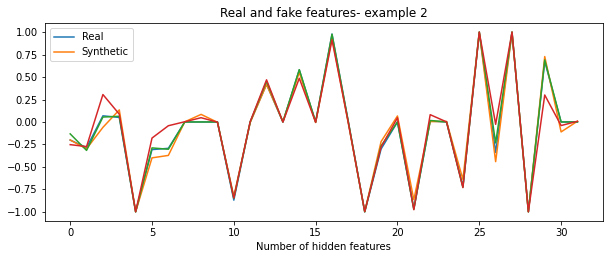

In [12]:
fixed_noise = torch.randn(len(RBBB),channels_noise,1).to("cpu")
RBBB_fake_HF = RBBB_gen(fixed_noise)
RBBB_fake_HF = RBBB_fake_HF.detach().numpy()

plt.figure(figsize=[10,8])
plt.subplot(211)
plt.plot(RBBB_HF[0])
plt.plot(RBBB_fake_HF[0][0])
plt.xlabel('Number of hidden features')
plt.title('Real and fake features- example 1')
plt.legend(['Real', 'Synthetic'])

plt.subplot(211)
plt.plot(RBBB_HF[1])
plt.plot(RBBB_fake_HF[1][0])
plt.xlabel('Number of hidden features')
plt.title('Real and fake features- example 2')
plt.legend(['Real', 'Synthetic'])

Use the decoder to transform the real and synthetic RBBB features in ECG heartbeats

In [13]:
# 1) Load the decoder
decoder_PATH = r'C:\Users\1938759.IKB\OneDrive - Brunel University London\Projects with Alex\EHRA- abstract\LSTM-AE feature extraction\models\decoder_RBBB.pth'
decoder_model = Decoder(seq_len, input_dim=32, n_features=1)
decoder_model.load_state_dict(torch.load(decoder_PATH))
decoder_model.eval()
decoder_model = decoder_model.to('cuda') 

# 2) Take the fake_noise generated by the generator and use the LSTM decoder to generate a fake signal
RBBB_fake_HF = RBBB_gen(fixed_noise).to('cuda') 
RBBB_HF = torch.tensor(np.array(RBBB_HF)).to('cuda') 

RBBB_real_ECG, _ = predict(decoder_model, RBBB_HF)
RBBB_synthetic_ECG, _ = predict(decoder_model, RBBB_fake_HF)

C:\envs\ailab\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([360, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\envs\ailab\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([1, 32])) that is different to the input size (torch.Size([360, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


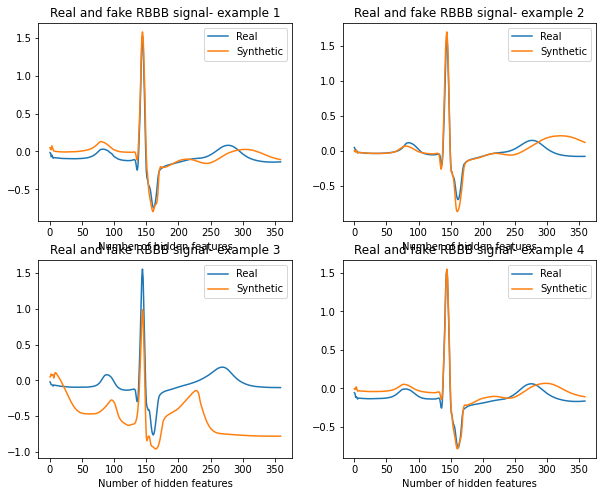

In [14]:
# real data is in RBBB

plt.figure(figsize=[10,8])
plt.subplot(2,2,1)
plt.plot(RBBB_real_ECG[0])
plt.plot(RBBB_synthetic_ECG[5])
plt.xlabel('Number of hidden features')
plt.title('Real and fake RBBB signal- example 1')
plt.legend(['Real', 'Synthetic'])

plt.subplot(2,2,2)
plt.plot(RBBB_real_ECG[1800])
plt.plot(RBBB_synthetic_ECG[1800])
plt.xlabel('Number of hidden features')
plt.title('Real and fake RBBB signal- example 2')
plt.legend(['Real', 'Synthetic'])

plt.subplot(2,2,3)
plt.plot(RBBB_real_ECG[800])
plt.plot(RBBB_synthetic_ECG[802])
plt.xlabel('Number of hidden features')
plt.title('Real and fake RBBB signal- example 3')
plt.legend(['Real', 'Synthetic'])

plt.subplot(2,2,4)
plt.plot(RBBB_real_ECG[1500])
plt.plot(RBBB_synthetic_ECG[1500])
plt.xlabel('Number of hidden features')
plt.title('Real and fake RBBB signal- example 4')
plt.legend(['Real', 'Synthetic'])

In [25]:
len(RBBB_real_ECG[0])

360

In [22]:
np.arange(0, len(RBBB_synthetic_ECG[5])/360, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

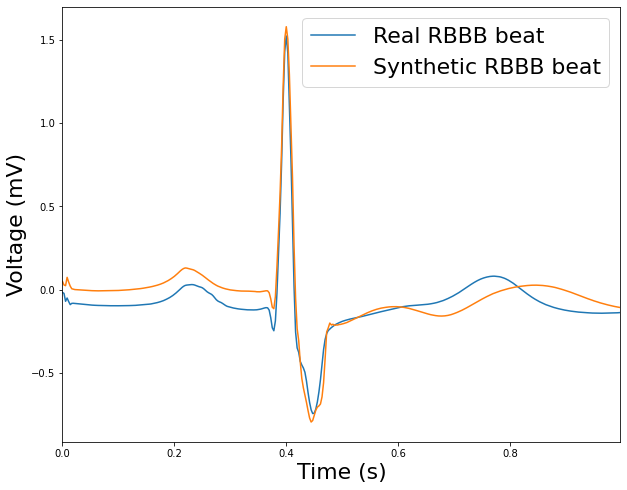

In [33]:
plt.figure(figsize=[10,8])


Fs = 360;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,len(RBBB_synthetic_ECG[5])/Fs,Ts) # time vector


plt.plot(t, RBBB_real_ECG[0])
plt.plot(t, RBBB_synthetic_ECG[5])
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Voltage (mV)', fontsize = 22)
#plt.title('Real and fake RBBB signal- example 1')
plt.legend(['Real RBBB beat', 'Synthetic RBBB beat'], fontsize=22)



plt.margins(x=0)

**AA ECG heartbeats generation**

In [36]:
# Load the GAN generator for RBBB heartbeats generation
# Run the 'hyperparameters' section before
PATH_gen = r'C:\Users\1938759.IKB\OneDrive - Brunel University London\Projects with Alex\EHRA- abstract\GAN-models\Generator_AA_MITdatabase.pth'
AA_gen = Generator(channels_noise, channels_img, features_g).to(device).to("cpu")
AA_gen.load_state_dict(torch.load(PATH_gen))

<All keys matched successfully>

Visualise the comparision between the real and synthetic **AA** features

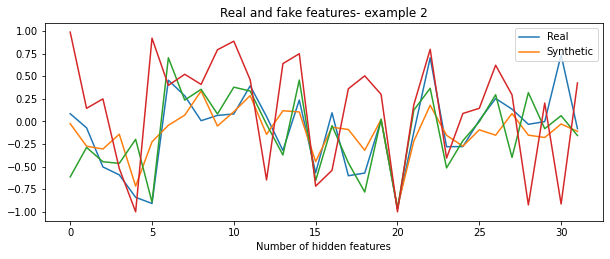

In [37]:
fixed_noise = torch.randn(len(RBBB),channels_noise,1).to("cpu")
AA_fake_HF = AA_gen(fixed_noise)
AA_fake_HF = AA_fake_HF.detach().numpy()

plt.figure(figsize=[10,8])
plt.subplot(211)
plt.plot(AA_HF[0])
plt.plot(AA_fake_HF[0][0])
plt.xlabel('Number of hidden features')
plt.title('Real and fake features- example 1')
plt.legend(['Real', 'Synthetic'])

plt.subplot(211)
plt.plot(AA_HF[1])
plt.plot(AA_fake_HF[1][0])
plt.xlabel('Number of hidden features')
plt.title('Real and fake features- example 2')
plt.legend(['Real', 'Synthetic'])

Use the decoder to transform the real and synthetic **AA** features in ECG heartbeats

In [38]:
# 1) Load the decoder
decoder_PATH = r'C:\Users\1938759.IKB\OneDrive - Brunel University London\Projects with Alex\EHRA- abstract\LSTM-AE feature extraction\models\AA_decoder.pth'
decoder_model = Decoder(seq_len, input_dim=32, n_features=1)
decoder_model.load_state_dict(torch.load(decoder_PATH))
decoder_model.eval()
decoder_model = decoder_model.to('cuda') 

# 2) Take the fake_noise generated by the generator and use the LSTM decoder to generate a fake signal
AA_fake_HF = AA_gen(fixed_noise).to('cuda') 
AA_HF = torch.tensor(np.array(AA_HF)).to('cuda') 

AA_real_ECG, _ = predict(decoder_model, AA_HF)
AA_synthetic_ECG, _ = predict(decoder_model, AA_fake_HF)

C:\envs\ailab\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([360, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\envs\ailab\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([1, 32])) that is different to the input size (torch.Size([360, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


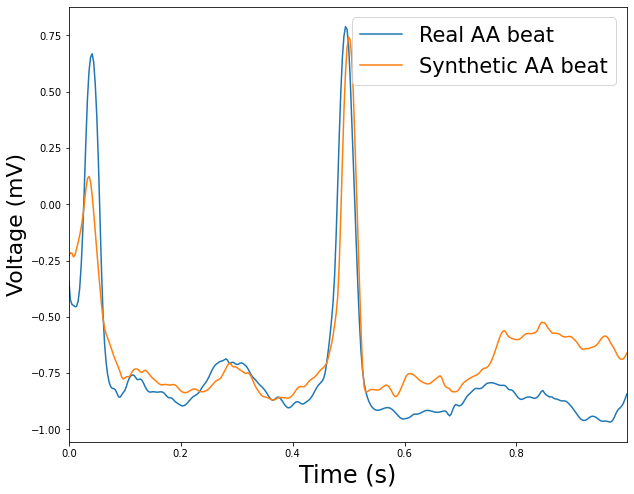

In [109]:
plt.figure(figsize=[10,8])


Fs = 360;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,len(AA_synthetic_ECG[5])/Fs,Ts) # time vector


plt.plot(t, AA_real_ECG[150])
plt.plot(t, AA_synthetic_ECG[180])
plt.xlabel('Time (s)', fontsize = 24)
plt.ylabel('Voltage (mV)', fontsize = 22)
#plt.title('Real and fake RBBB signal- example 1')
plt.legend(['Real AA beat', 'Synthetic AA beat'], fontsize=21)



plt.margins(x=0)

In [95]:
dist = [[abs(np.mean(AA_real_ECG[i]) - np.mean(AA_synthetic_ECG[i]))] for i in range(len(AA_synthetic_ECG))]

IndexError: list index out of range